In [1]:
# Veri okuma ve işleme
import cv2
import urllib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import random, os, glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from urllib.request import urlopen

# Uyarıları kapatma
import warnings
warnings.filterwarnings("ignore")

# Resim İndirme
import urllib.request
from PIL import Image
from io import BytesIO

# Model Değerlendirme
from sklearn.metrics import classification_report, confusion_matrix

# Model Kurma
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, SpatialDropout2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

## Verisetinin Okunması

In [2]:
dir_path = "wonderland"

In [3]:
target_size = (224, 224)

w_labels = {"cat":0, "deer":1, "dog":2, "human":3, "parrot":4, "shark":5}
w_labels_1 = {0:"cat", 1:"deer", 2:"dog", 3:"human", 4:"parrot", 5:"shark"}

In [4]:
def load_datasets(path):

    x = []
    labels = []

    image_paths = sorted(list(paths.list_images(path)))

    for image_path in image_paths:
        img = cv2.imread(image_path)

        img = cv2.resize(img, target_size)

        x.append(img)

        label = image_path.split(os.path.sep)[-2]

        labels.append(w_labels[label])

        x, labels = shuffle(x, labels, random_state=42)

    print(f"X boyutu: {np.array(x).shape}")
    print(f"Label boyutu: {len(labels)}")
    print(f"Label sınıf sayısı: {len(np.unique(labels))}")

    return x, labels

In [5]:
X, labels = load_datasets(dir_path)

X boyutu: (600, 224, 224, 3)
Label boyutu: 600
Label sınıf sayısı: 6


In [6]:
input_shape = (np.array(X).shape[-3], np.array(X).shape[-2], np.array(X).shape[-1])

In [7]:
def visualize_img(image_batch, label_batch, num):
    plt.figure(figsize=(10, 10))
    for n in range(num):
        plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(w_labels_1[labels[n]])
        plt.axis("off")

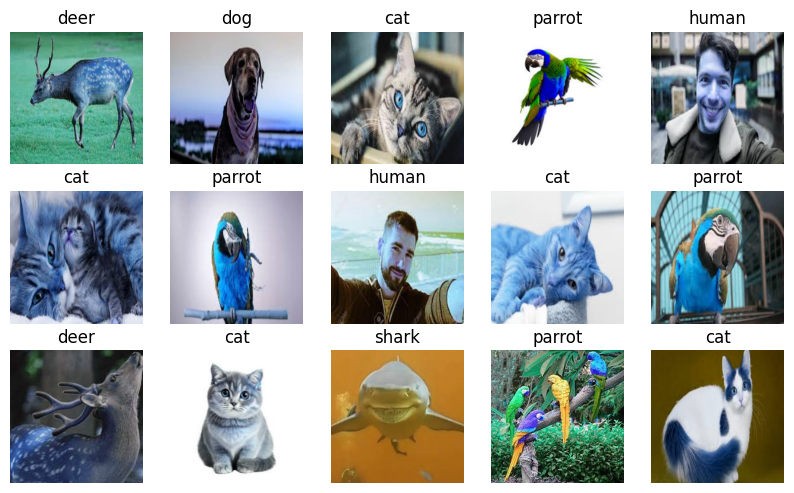

In [8]:
visualize_img(X, labels, 15)

## Veri Artırma (Data Augmentation)

In [9]:
train = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    validation_split = 0.1,
    rescale = 1/255,
    shear_range = 0.1,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1
    )

test = ImageDataGenerator(
    rescale = 1/255,
    validation_split = 0.1
)

In [10]:
train_generator = train.flow_from_directory(
    directory = dir_path,
    target_size = target_size,
    class_mode = "categorical",
    subset = "training"
)

test_generator = test.flow_from_directory(
    directory = dir_path,
    target_size = target_size,
    batch_size = 100,
    class_mode = "categorical",
    subset = "validation"
)

Found 540 images belonging to 6 classes.
Found 60 images belonging to 6 classes.


## CNN Modeli Kurma

In [34]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", input_shape=input_shape, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())

model.add(Dense(units=64, activation="relu"))
model.add(Dropout(rate=0.3))

model.add(Dense(units=64, activation="relu"))
model.add(Dropout(rate=0.3))

model.add(Dense(units=6, activation="softmax"))

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 56, 56, 64)       

## Optimizasyon ve Değerlendirme Metriklerinin Ayarlanması

In [36]:
optimizer = Adam(learning_rate=0.0001)
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)

In [37]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=20, mode="min", verbose=1),
    ModelCheckpoint(filepath="wonderland.h5", monitor="val_accuracy", mode="max", save_best_only=True, save_weights_only=False, verbose=1)
]

## Modelin Eğitilmesi

In [38]:
history = model.fit_generator(
    generator = train_generator,
    epochs = 100,
    validation_data = test_generator,
    callbacks = callbacks,
    workers = 4,
    steps_per_epoch = 54,
    validation_steps = 6
)

Epoch 1/100
54/54 [==============================] - ETA: 0s - loss: 1.6142 - accuracy: 0.3738
Epoch 1: val_accuracy improved from -inf to 0.41667, saving model to wonderland.h5
54/54 [==============================] - 30s 530ms/step - loss: 1.6142 - accuracy: 0.3738 - val_loss: 1.7295 - val_accuracy: 0.4167
Epoch 2/100
54/54 [==============================] - ETA: 0s - loss: 1.3523 - accuracy: 0.4674
Epoch 2: val_accuracy improved from 0.41667 to 0.61667, saving model to wonderland.h5
54/54 [==============================] - 29s 532ms/step - loss: 1.3523 - accuracy: 0.4674 - val_loss: 1.6617 - val_accuracy: 0.6167
Epoch 3/100
54/54 [==============================] - ETA: 0s - loss: 1.2665 - accuracy: 0.5099
Epoch 3: val_accuracy did not improve from 0.61667
54/54 [==============================] - 29s 536ms/step - loss: 1.2665 - accuracy: 0.5099 - val_loss: 1.5939 - val_accuracy: 0.5833
Epoch 4/100
54/54 [==============================] - ETA: 0s - loss: 1.1735 - accuracy: 0.5571
Epoc

## Doğruluk ve Kayıp Grafikleri

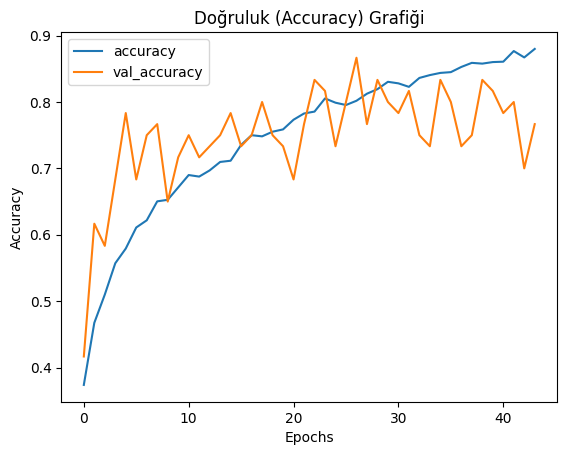

In [39]:
acc = pd.DataFrame(history.history)[["accuracy","val_accuracy"]]
acc.plot()
plt.title("Doğruluk (Accuracy) Grafiği")
plt.xlabel("Epochs")
plt.ylabel("Accuracy");

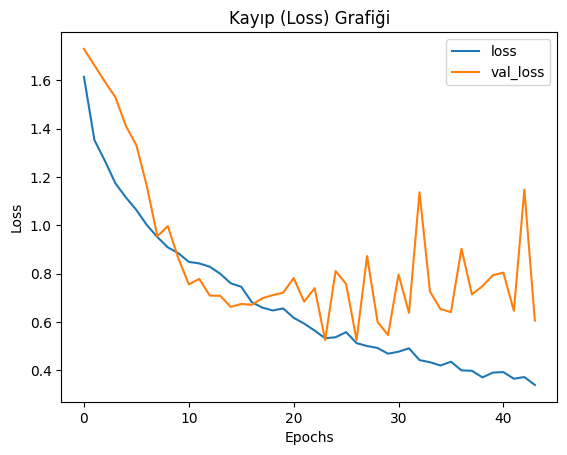

In [40]:
loss = pd.DataFrame(history.history)[["loss","val_loss"]]
loss.plot()
plt.title("Kayıp (Loss) Grafiği")
plt.xlabel("Epochs")
plt.ylabel("Loss");

## Model Değerlendirme (Evaluation)

In [41]:
loss, acc = model.evaluate(test_generator, batch_size=10)

1/1 [==============================] - 0s 259ms/step - loss: 0.6057 - accuracy: 0.7667


In [42]:
print(f"Loss: {loss*100:.2f}% \nAccuracy: {acc*100:.2f}%")

Loss: 60.57% 
Accuracy: 76.67%


In [43]:
images, labels = test_generator.next()
images, labels = test_generator.next()
images, labels = test_generator.next()

In [44]:
y_pred = model.predict(images)

2/2 [==============================] - 0s 96ms/step


In [45]:
y_pred = [np.argmax(i) for i in y_pred]

In [46]:
labels = [np.argmax(i) for i in labels]

In [47]:
print(classification_report(labels, y_pred, target_names=w_labels))

              precision    recall  f1-score   support

         cat       0.86      0.60      0.71        10
        deer       0.57      0.80      0.67        10
         dog       0.50      0.30      0.37        10
       human       0.90      0.90      0.90        10
      parrot       0.77      1.00      0.87        10
       shark       1.00      1.00      1.00        10

    accuracy                           0.77        60
   macro avg       0.77      0.77      0.75        60
weighted avg       0.77      0.77      0.75        60



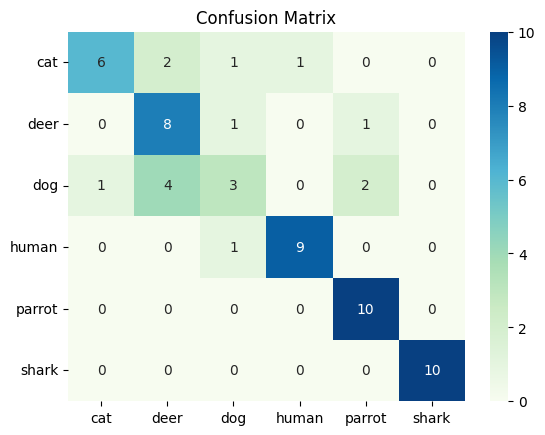

In [48]:
sns.heatmap(confusion_matrix(labels, y_pred), annot=True, xticklabels=w_labels.keys(), yticklabels=w_labels.keys(), cmap="GnBu")
plt.yticks(rotation=0)
plt.title("Confusion Matrix");

## Modeli Kullanma

In [49]:
wonder_model = load_model("wonderland.h5")

In [50]:
def predict_images(path):

    # path: görsellerin dizini

    images = []
    classes = []
    probs = []

    image_paths = sorted(list(paths.list_images(path)))
    image_paths = shuffle(image_paths)[:7]

    for img_path in image_paths:
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0

        predictions = wonder_model.predict(img_array, verbose=0)
        predicted_class_index = np.argmax(predictions)
        predicted_class_prob = np.max(predictions)
        class_name = w_labels_1[predicted_class_index]

        images.append(img_array)
        classes.append(class_name)
        probs.append(predicted_class_prob)

    return images, classes, probs

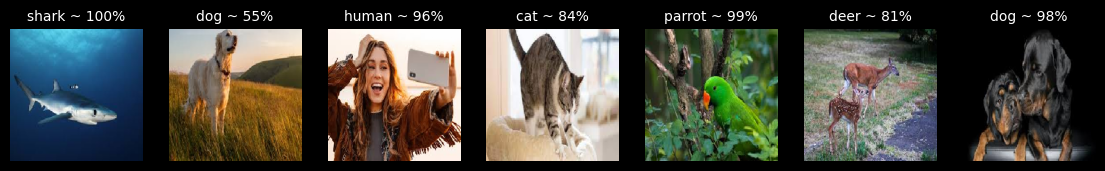

In [52]:
# Eğitim ve Test görselleri üzerinden çoklu tahmin
images, classes, probs = predict_images(dir_path)
plt.figure(figsize=(14, 14)).set_facecolor("black")
for i in range(7):
    plt.subplot(1, 7, i+1)
    plt.imshow(images[i].squeeze())
    plt.title(f"{classes[i]} ~ {probs[i]*100:.0f}%", fontsize=10, color="white")
    plt.axis("off")

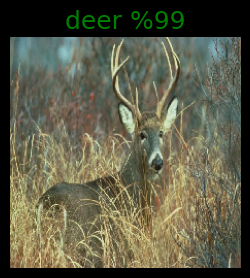

In [59]:
# Tekli Görsel Tahmini

# herhangi bir resim linki girin:
resim_url = "https://www.adirondackalmanack.com/wp-content/uploads/2016/05/male-whitetail-deer.jpg"

# görseli okuma ve kaydetme
try:
    resim_response = urllib.request.urlopen(resim_url)
    resim_data = BytesIO(resim_response.read())
    resim = Image.open(resim_data)
    resim.save('resim.jpg')
except:
    print("Görsele ulaşılamadı.")

# dönüştürme
img = image.load_img("resim.jpg", target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# tahmin
predictions = wonder_model.predict(img_array, verbose=0)
predicted_class_index = np.argmax(predictions)
predicted_class_prob = np.max(predictions)
class_name = w_labels_1[predicted_class_index]

# görselleştirme
plt.figure(figsize=(3, 3)).set_facecolor("black")
plt.imshow(img_array.squeeze())
plt.title(f"{class_name} %{predicted_class_prob*100:.0f}", fontsize=18, color="green")
plt.axis("off");